# DSC 200 Final project

This project involves the analysis of a climate projection of temperature change across the Earth under a 'middle-of-the-road' future scenario in which global mean temperatures reach more than 2 degress centigrade above the pre-industrial. You will read in the data, analyze it, and visualize it in a variety of ways. You will also write a small command line interface to make the analysis more interactive. 

We will be using data created by the NorESM2 climate model and processed and as part of the ClimateBench [dataset](https://zenodo.org/records/7064308), described in this [paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002954). **All the files you will need for this project are available in the `public` folder on DataHub though.**

### Table of contents:

 1. [Read in CO2 emissions data for historical + future scenario](#1.-Read-in-historical-and-future-(estimated)-CO2-emissions-data) [5 points]
 2. [Read in temperature data](#2.-Read-in-the-temperature-data) [5 points]
 3. [Create a simple regression model](#3.-Create-a-simple-regression-model-of-global-warming) [15 points]
 4. [Extend this to a regional temperature model, by region, and by state](#4.-Extend-this-to-a-regional-temperature-model,-by-region,-and-by-state) [15 points]
 5. [Plot the regression coefficients for each country](#5.-Plot-the-regression-coefficients-for-each-country) [5 points]
 6. [Do an analysis of your choosing](#6.-Do-an-analysis-of-your-choosing) [15 points]
 7. [Make a command line interface](#7.-Make-a-command-line-interface-to-a-prediction-script) [20 points]
 
### Other requirements:
 You will also be graded on Documentation and commenting, coding sytle, and code quality:
 - Documentation should be in the form of a Jupyter notebook, and should include a description of the data, the analysis, and the results. [10 points]
 - The code should be well documented, and should follow the PEP8 coding style. [5 points]
 - The code should be well organized, and should be broken up into functions and classes as appropriate. For full marks try to use no for-loops in your code. [5 points]
 - Submit your work on both datahub and gradescope.

Be sure to read the question and reach out to the instructor or TA if you have any questions.

### Total points: 100 (30% of total), plus midterm makeup
 - Note, the midterm grade is still capped at 100%

### Deadline: Sunday December 11th 11:59pm


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## 1. Read in historical and future (estimated) CO2 emissions data

Monthly CO2 emissions data is available since 1850 globally for each industrial sector. We want to use annual average totals of the emissions for all sectors for our analysis. Since CO2 has a very long lifetime in the atmosphere (1000's of years), we can assume that the total amount of anthropogenic CO2 in the atmosphere is the cumulative sum of all emissions since 1850. This is what we will use for our analysis.

To read this data do **either** Q1a (to get 5 points plus additional makup points for the midterm) **or** Q1b (to get 5 points for this project)

In [2]:
input_path = '~/public/Project_data/'

### 1a. OPTIONAL: Create interpolated cumalitve CO2 from the raw data using Pandas

To gain (up to) 50% additional marks for your midterm makeup (capped at 100%), you can create a new column in the CO2 emissions data that is the cumulative CO2 emissions. 

In [3]:
# These input files provide CO2 emissions data for the historical period (1850-2014) and the future period (2015-2100). They should all be concatenated into a single file.

historical_input_files = [input_path+'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv',
                          input_path+'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv',
                          input_path+'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv',
                          input_path+'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv']

future_input_file = input_path+'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.csv'

First you will need to read, concatenate and process the raw CSV files, and sum over the `sector` and `month` columns to get an annual total.

**Function**: `read_co2_data`

**Description**
Reads and aggregates historical CO2 data from multiple CSV files, returning a DataFrame with total CO2 emissions per year.

**Inputs**
- **historical_input_files** (`list[str]`): A list of file paths to CSV files containing 'year', 'month', and 'global_total' columns.

**Outputs**
- **pd.DataFrame**: DataFrame with columns:
    - **year** (`int`): The year of the CO2 data.
    - **global_total** (`float`): Total CO2 emissions per year.

In [4]:
def read_co2_data(historical_input_files):
    """
    Reads and aggregates historical CO2 data from multiple CSV files.

    Args:
        historical_input_files (list[str]): 
            List of file paths to CSV files containing 'year', 'month', and 'global_total' columns.

    Returns:
        pd.DataFrame: 
            A DataFrame with columns:
            - 'year' (int): The year of the CO2 data.
            - 'global_total' (float): Total CO2 emissions per year.
    """
    # Initialize an empty DataFrame
    CO2_data = pd.DataFrame()

    # Concatenate data from all files
    for name in historical_input_files:
        CO2_data = pd.concat([CO2_data, pd.read_csv(name)])

    # Aggregate CO2 emissions by year and sort by year
    CO2_data = (CO2_data.groupby('year')
                        .sum('global_total')
                        .drop('month', axis=1)
                        .reset_index()
                        .sort_values('year'))

    return CO2_data

CO2_data = read_co2_data(historical_input_files)

**Note**, the future data is only provided every five years so that will need linearly intepolated to get annual values.

**Function**: `read_preprocess_future_data`

**Description**  
Reads and processes future CO2 data, interpolating missing values and calculating yearly CO2 totals.

**Inputs**  
- **future_input_file** (`str`): File path to the CSV file containing future CO2 data with 'year', 'month', and 'global_total' columns.

**Outputs**  
- **pd.DataFrame**: DataFrame with:
  - **year** (`int`): Years from 2015 to 2100.
  - **global_total** (`float`): Interpolated yearly CO2 totals.

In [5]:
def read_preprocess_future_data(future_input_file):
    """
    Reads and processes future CO2 data, interpolating missing values and calculating yearly CO2 totals.

    Args:
        future_input_file (str): 
            File path to the CSV file containing future CO2 data with 'year', 'month', and 'global_total' columns.

    Returns:
        pd.DataFrame: 
            A DataFrame with:
            - 'year' (int): Years from 2015 to 2100.
            - 'global_total' (float): Interpolated yearly CO2 totals.
    """
    # Read future CO2 data from the input file
    future = pd.read_csv(future_input_file)

    # Calculate yearly CO2 totals and remove the 'month' column
    future = future.groupby('year').sum('global_total')
    future = future.drop('month', axis=1)

    # Create a DataFrame with all years from 2015 to 2100
    future_full_years = pd.DataFrame(index=np.arange(2015, 2101))

    # Interpolate missing values for CO2 totals
    future_full_years['global_total'] = (
        future['global_total']
        .reindex(future_full_years.index)
        .interpolate(method='linear')
    )

    # Reset index and rename columns
    future_full_years = future_full_years.reset_index().rename(columns={'index': 'year'})

    return future_full_years

future_full_years = read_preprocess_future_data(future_input_file)

Now, divide by 1e6 to get the units in GtC (Giga tonnes of carbon) and calculate the cumulative sum.

In [6]:
## Concatenate the historical and future CO2 data, and calculate the cumulative CO2
## Drop the global_total column
CO2_data = pd.concat([CO2_data, future_full_years])
CO2_data = CO2_data.assign(
    cumulative_CO2=CO2_data['global_total'].cumsum() / 1e6
).drop('global_total', axis=1)

Check the data against the existing `combined_co2.csv` and save it to use for the rest of the project.

In [7]:
## Compare the cumulative CO2 values
pre_processed_input_file = input_path+'combined_co2.csv'

## Read the input files
df=pd.read_csv(pre_processed_input_file)

## See whether they are the same
## Use np.isclose to avoid floating point error
np.all(np.isclose(df['global_total'], CO2_data['cumulative_CO2']))

np.True_

### 1b. Otherwise just read in the cumulative CO2 emissions data from the provided file

In [8]:
pre_processed_input_file = input_path+'cumulative_co2.csv'

## Read the input files
df=pd.read_csv(pre_processed_input_file)

### Section Summary

In this section, we prepeocessed the CO2 data, and compared it with the combined CO2 data. Finally we found that the data we calculated is the same as the data provided. The after-processed dataframe is 
$$
CO2\_data
$$

## 2. Read in the temperature data

Note, this temperature change as modelled by the NorESM2 climate model relative to the pre-industrial period. It's purely driven by the prescribed emissions, so it won't perfect represent the actual temperatures we experienced in a given year (which are subject to chaotic fluctuations), but it's a good model.

In [9]:
temperture_input_file = input_path+'global_temparature.nc'
temp_data = xr.open_dataset(temperture_input_file)

And take the global mean. Don't forget to calculate and include weights for the latitude of each grid cell.

**Function**: `compute_weights`

**Description**  
Computes the area-based weights for each grid cell in a latitude-longitude grid.

**Inputs**  
- **temp** (`xr.Dataset`): Dataset with 'tas' variable and 'lat', 'lon' coordinates.

**Outputs**  
- **xr.DataArray**: Weights for each grid cell based on latitude and longitude.

In [10]:
def compute_weights(temp: xr.Dataset) -> xr.DataArray:
    """
    Computes the area-based weights for each grid cell in a latitude-longitude grid.

    Args:
        temp (xr.Dataset): Dataset with 'tas' variable and 'lat', 'lon' coordinates.

    Returns:
        xr.DataArray: Weights for each grid cell based on latitude and longitude.
    """
    dϕ = np.deg2rad(2.5)  # Latitude spacing
    dλ = np.deg2rad(2.5)  # Longitude spacing

    # Calculate latitude and longitude weights
    dlat = dϕ * xr.ones_like(temp.tas.lon)
    dlon = dλ * np.cos(np.deg2rad(temp.tas.lat))

    # Compute combined weights
    weights = dlon * dlat
    return weights

weights = compute_weights(temp_data)
avg_temp = temp_data.weighted(weights).mean(dim=['lon', 'lat'])

### Section Summary

In this section, we calculated the weights for each grid, and we added it to the temperature. Finally, we get the xarray.Dataset named
$$
avg\_temp
$$

## 3. Create a simple regression model of global warming

Global warming can be surprisingly well predicted just using a linear model of cumulative CO2 emissions. This is because the CO2 emissions are the primary driver of global warming, and the CO2 stays in the atmosphere for a long time (see e.g. https://www.nature.com/articles/ngeo3031).

To get global temperature as a function of cumaltive CO2. You can use the `LinearRegression` class from `sklearn.linear_model`, with documentation provided [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). You should only need to use the `fit` and `predict` methods. The `fit` method takes two arguments, the first is the input data, and the second is the output data. The `predict` method takes one argument, the input data.

Alternatively, you can also use the `statsmodels` package to get more detailed statistics on the regression. See [here](https://www.statsmodels.org/stable/regression.html) for documentation.

Since we're only aiming to create an interpolation model, we don't need to worry too much about keeping a test set aside. We can just use all the data to train the model. You could also use a train-test split if you want to.

Firstly we need to import the package we need to use

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
## Extract the cumulative CO2 and temperature firstly
CO2_emissions = CO2_data['cumulative_CO2'].values
temps = avg_temp['tas'].values

## And then do the regression
CO2_temp_reg = LinearRegression()
CO2_temp_reg.fit(CO2_emissions.reshape(-1, 1), temps)

LinearRegression()

Plot gobal mean temperature as a function of cumalative CO2 emissions, along with the regression fit


Text(0.5, 1.0, 'Global Mean Temperature vs. Cumulative CO2')

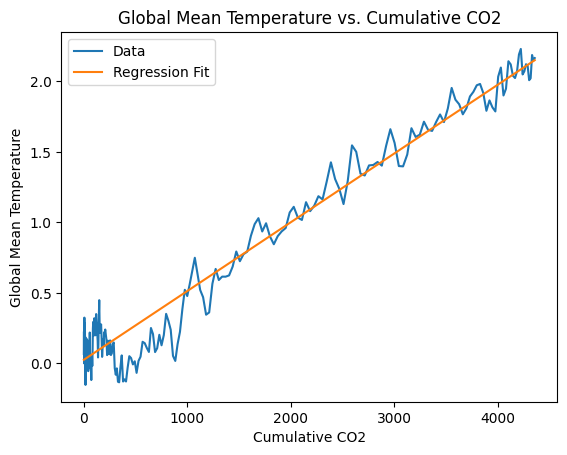

In [13]:
# Plot the image

plt.plot(CO2_emissions, temps)
plt.plot(CO2_emissions, CO2_temp_reg.predict(CO2_emissions.reshape(-1, 1)))
plt.legend(["Data", "Regression Fit"])
plt.xlabel("Cumulative CO2")
plt.ylabel("Global Mean Temperature")
plt.title("Global Mean Temperature vs. Cumulative CO2")

Plot gobal mean temperature as a function of year, along with the regression fit

Text(0.5, 1.0, 'Global Mean Temperature vs. Time')

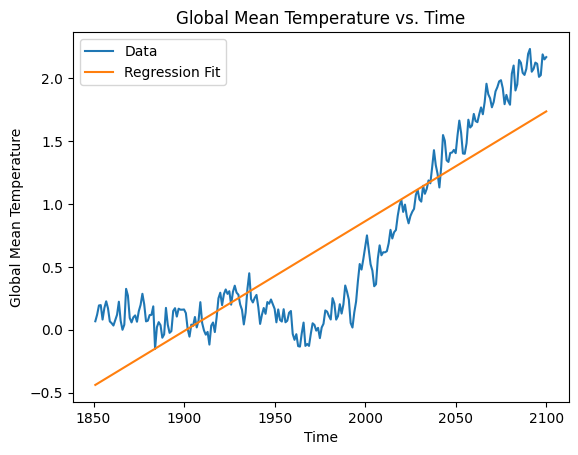

In [14]:
## Extract the time
times = avg_temp['time'].values

## And then do the regression
temp_reg = LinearRegression()
temp_reg.fit(times.reshape(-1, 1), temps)

## Plot the image
plt.plot(times, temps)
plt.plot(times, temp_reg.predict(times.reshape(-1, 1)))
plt.legend(['Data', 'Regression Fit'])
plt.xlabel('Time')
plt.ylabel('Global Mean Temperature')
plt.title('Global Mean Temperature vs. Time')

### Section Summary

In this section we calculated 2 simple linear regression, and ploted the figures for Global Mean Temperature vs. Cumulative CO2 and Global Mean Temperature vs. Time.

We can find that the global mean temperature grows as the cumulative CO2 grows or the time growth.

## 4. Extend this to a regional temperature model, by region, and by state

While the relationship between global temperature and cumulative CO2 emissions is very linear, the relationship between regional temperature and cumulative CO2 emissions is less so. This is because the regional temperature is affected by other factors, such as the regional distribution of land and ocean, and the regional distribution of CO2 emissions. Nevertheless, let's see how well it can do

Read in the country mask which is a 2D array of the same size as the temperature data, with each grid cell containing the country code of the country that grid cell is in.

We read data firstly, and modify the complex name.

In [15]:
country_mask_file = input_path+'country_mask.nc'

def read_and_modify(country_mask_file: str) -> xr.Dataset:
    """
    Read the country mask file and rename the variable for easier use.

    Args:
        country_mask_file (str): File path to the country mask dataset.

    Returns:
        xr.Dataset: Dataset with the 'country' variable renamed.
    """
    # Open the country mask dataset
    countries = xr.open_dataset(country_mask_file)

    # Rename the variable for easier access
    countries = countries.rename({'__xarray_dataarray_variable__': 'country'})

    return countries

countries = read_and_modify(country_mask_file)

Average the spatial coordinates into countries so that you end up with a dataset that has dimensionality of the number of countries by the number of time points.

**Function**: `align_data`

**Description**  
Aligns the data to the countries.

**Inputs**  
- **temp_data** (`xr.Dataset`): Dataset with 'tas' variable and 'lat', 'lon' coordinates.
- **weights** (`xr.DataArray`): Weights for each grid cell based on latitude and longitude.
- **countries** (`xr.Dataset`): Dataset with 'country' variable.

**Outputs**  
- **xr.Dataset, xr.DataArray**: Aligned `temp_data` and `weights`.

In [16]:
## Firstly we should align the countries dataset to the temperature dataset
def align_data(temp_data, weights, countries):
    """
    Align the data to the countries.

    Args:
        temp_data: Dataset with 'tas' variable and 'lat', 'lon' coordinates.
        weights: Weights for each grid cell based on latitude and longitude.
        countries: Dataset with 'country' variable.

    Returns:
        Aligned temp_data and weights.
    """
    ## Assign the coordinates to temp_data and weights
    temp_data = temp_data.assign_coords(countries)
    weights = weights.assign_coords(countries)
    return temp_data, weights

temp_data, weights = align_data(temp_data, weights, countries)

## Groupby Countries
# Calculate the warming * weights, and groupby countries
temp_by_country = temp_data\
    .assign(warming = temp_data.tas * weights)\
    .groupby('country').sum()

# Calculate each country's weights
weights_by_country = weights.groupby('country').sum()

# Calculate the warming / weights
temp_by_country = temp_by_country\
    .assign(warming = temp_by_country.warming / weights_by_country)\
    .drop_vars('tas')

Now we have successfully aligned the data, the dataset temp_by_country has time, country as coordinate, and warming as the data

Ploting the figure for each country is difficult, we create a new function to do this multiple work.

In [18]:
def plot_by_country(x_data, y_data, title, x_label, y_label):
    """
    Plot the data by country.
    """
    plt.figure(figsize=(35, 10))
    plt.bar(x_data, y_data)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=90);
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.title(title, fontsize=20)

Plot a bar chart of the warming in each country in 2023. Note, the temperature data is baselined to 1850.

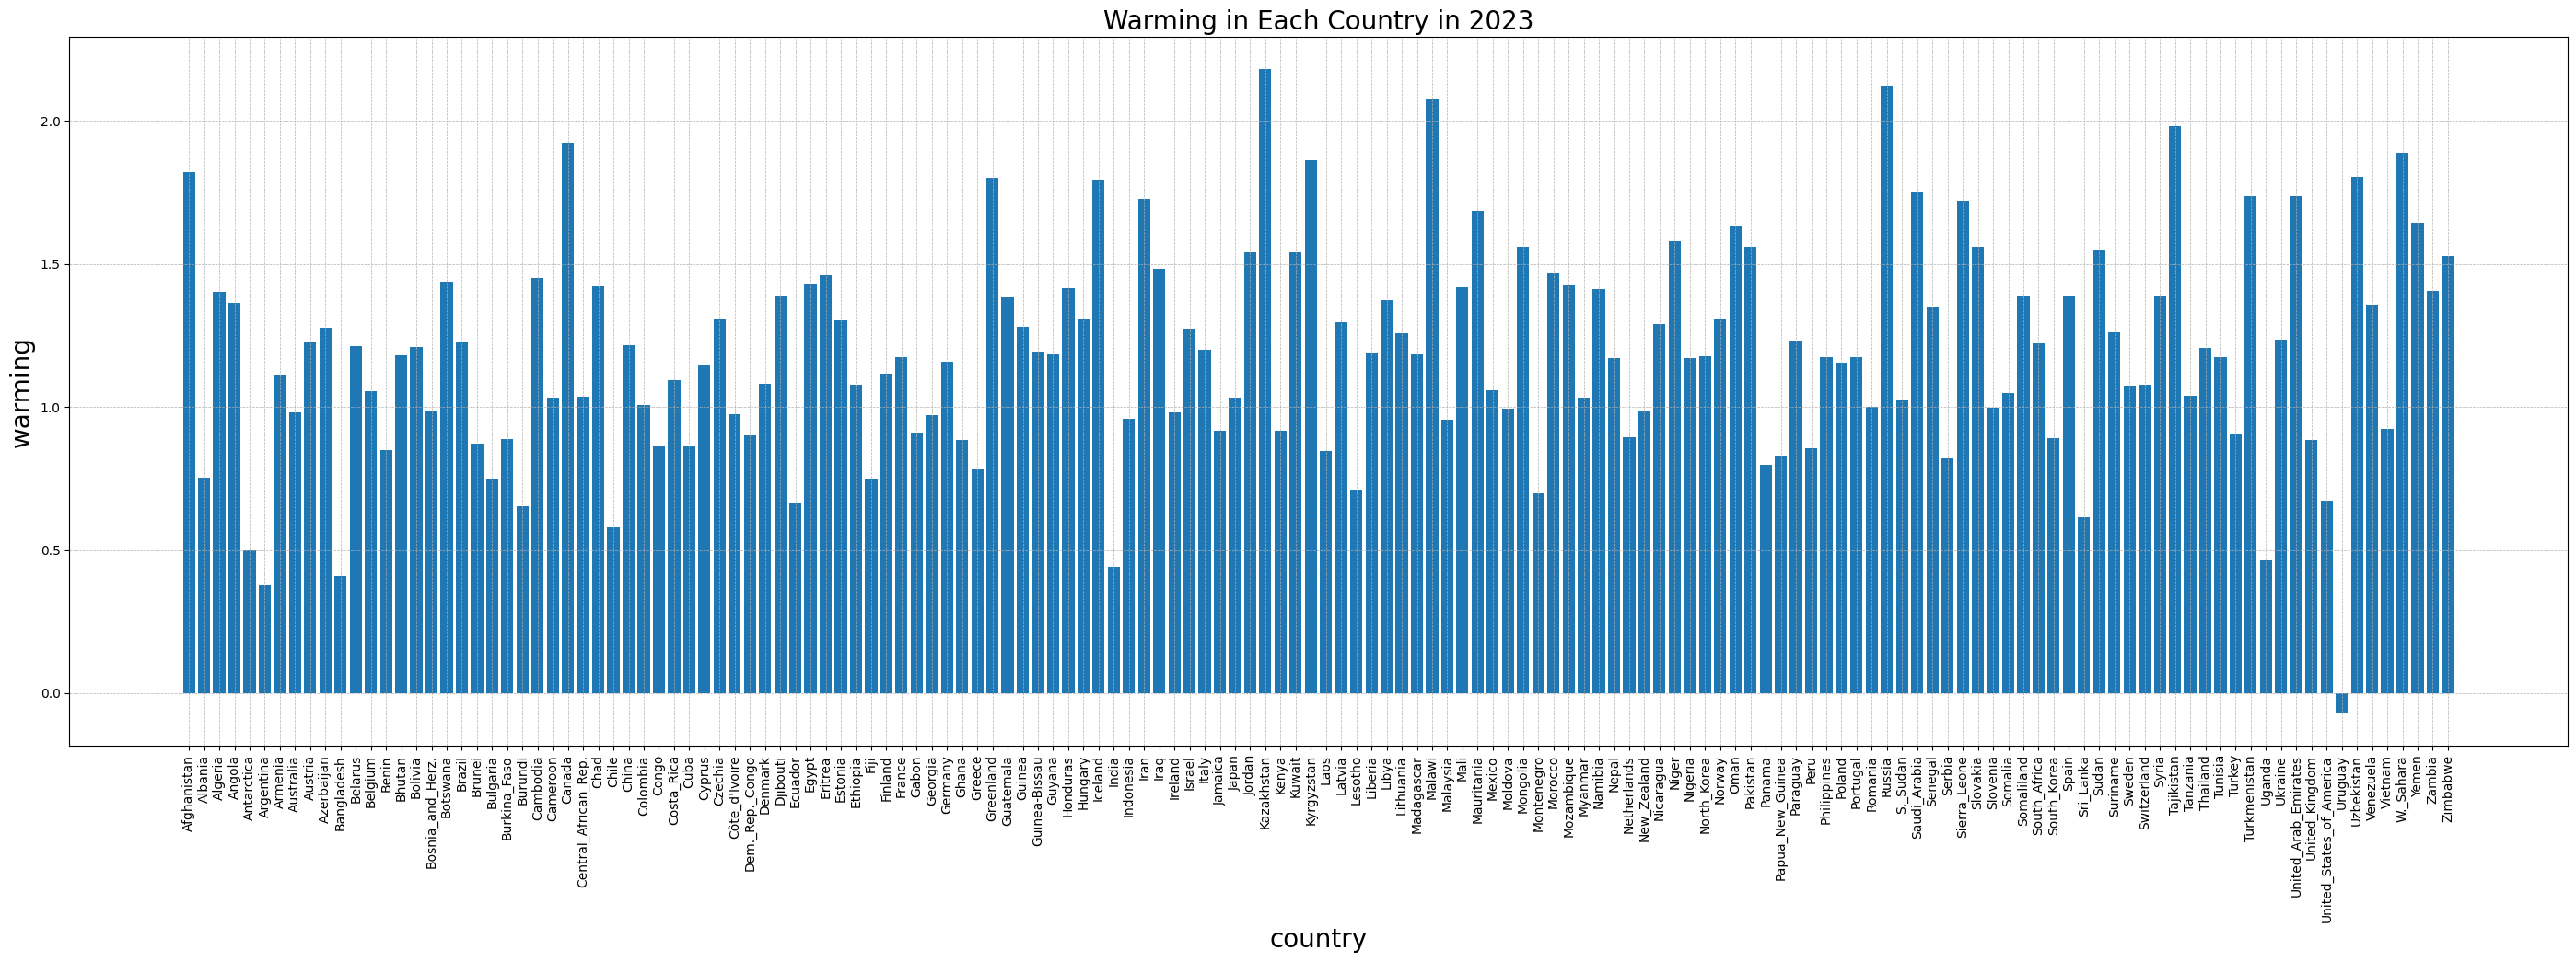

In [19]:
## Plot
# Prepare the data
data = temp_by_country.sel(time=2023)
x = data.country
y = data.warming

# Plot
plot_by_country(x, y, 'Warming in Each Country in 2023', 'country', 'warming')

Calculate a linear regression model for each country along with the R^2 value. Plot the R^2 values for each country as a bar chart.

In [20]:
## Turn CO2_data into xarray after changing the index
CO2_data = CO2_data.set_index('year')
CO2_data.index.name = 'time'
CO2_emission = CO2_data.to_xarray()

In [21]:
## Using xr.polyfit to fit a polynomial(Do linear regression)
## and compute the prediction
temp_by_country = temp_by_country.assign_coords(CO2_emission = CO2_emission.cumulative_CO2)
paras = temp_by_country.polyfit('CO2_emission', deg=1)
pred = xr.polyval(temp_by_country.CO2_emission, paras.warming_polyfit_coefficients)

Since the function which calculating R^2 in sklearn cannot align the country perfectly, we calculate the R^2 by hand.

**Function**: `compute_r2`

**Description**  
Computes the R-squared value between observed and predicted temperature data.

**Inputs**  
- **temp_by_country** (`xr.Dataset`): Dataset with actual temperature data.
- **pred** (`xr.Dataset`): Dataset with predicted temperature data.

**Outputs**  
- **xr.DataArray**: R-squared values for each country.

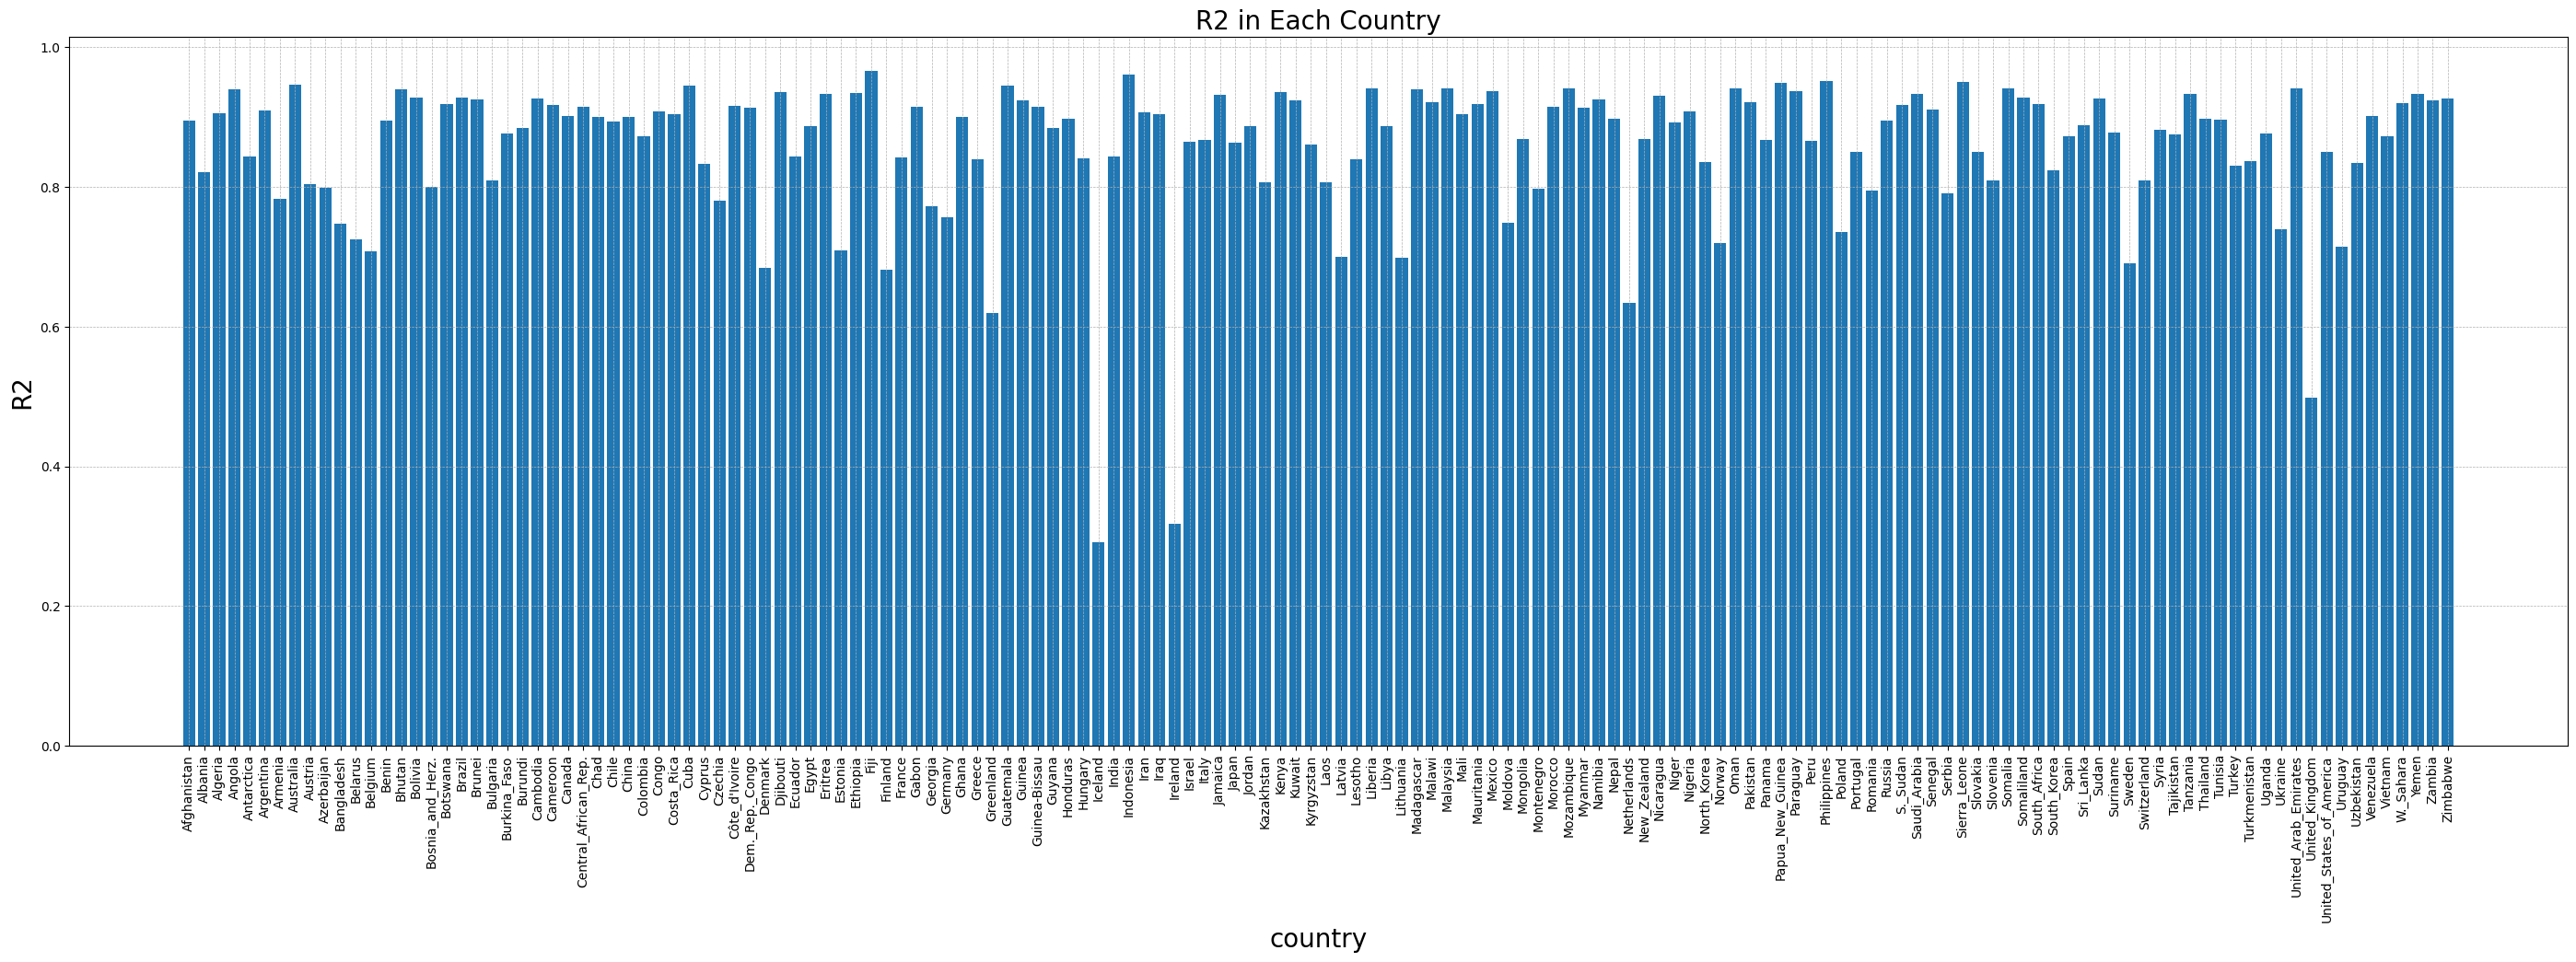

In [30]:
# Calculete the R2 in each country
def compute_r2(temp_by_country, pred):
    """
    Compute the R-squared value between observed and predicted temperature data.

    Args:
        temp_by_country: Dataset with actual temperature data.
        pred: Dataset with predicted temperature data.

    Returns:
        xr.DataArray: R-squared values for each country.
    """
    # Compute res
    res = ((temp_by_country.warming - pred) ** 2).sum(axis=1)

    # Compute tot
    tot = (((temp_by_country.warming - temp_by_country.warming.mean(axis=1))) ** 2).sum(axis=1)

    # Calculate R-squared
    r2 = 1 - res / tot
    return r2

r2 = compute_r2(temp_by_country, pred)

## Plot
plot_by_country(x, r2, 'R2 in Each Country', 'country', 'R2')

For which countries does the linear assumption work well, and where does it work less well?

In [31]:
def find_and_print(data, top=True):
    """
    Find and print the top or bottom 5 values in the dataset.

    Args:
        data: The dataset to search through.
        top (bool): Whether to find the top 5 (True) or bottom 5 (False) values. Default is True.
    """
    # Get sorted indices of the flattened data (descending order)
    flat_indices = np.argsort(data.values.flatten())[::-1]

    # Select top or bottom 5 values based on the 'top' flag
    if top:
        indices = flat_indices[:5]
        flag = 'top'
    else:
        indices = flat_indices[-5:]
        flag = 'bottom'

    # Get the coordinates and corresponding values
    coords = np.unravel_index(indices, data.shape)
    values = data.values[coords]

    # Convert coordinates to a dictionary of dimension names and values
    coordinates = [
        {dim: data.coords[dim][index].item() for dim, index in zip(data.dims, idx)}
        for idx in zip(*coords)
    ]

    # Print the values and corresponding coordinates (with 8 decimal places)
    if top:
        for i, (value, coord) in enumerate(zip(values, coordinates)):
            print(f"the {i+1} the {flag} value: {value:.8f}, Country: {coord['country']}")
    else:
        for i, (value, coord) in enumerate(zip(values, coordinates)):
            print(f"the {5 - i} the {flag} value: {value:.8f}, Country: {coord['country']}")

In [32]:
find_and_print(r2, top=True)
find_and_print(r2, top=False)

the 1 the top value: 0.96632633, Country: Fiji
the 2 the top value: 0.96128221, Country: Indonesia
the 3 the top value: 0.95168767, Country: Philippines
the 4 the top value: 0.95075047, Country: Sierra_Leone
the 5 the top value: 0.94869670, Country: Papua_New_Guinea
the 5 the bottom value: 0.63352530, Country: Netherlands
the 4 the bottom value: 0.61975520, Country: Greenland
the 3 the bottom value: 0.49813124, Country: United_Kingdom
the 2 the bottom value: 0.31787282, Country: Ireland
the 1 the bottom value: 0.29135920, Country: Iceland


By the data showed above, we can find the country that the linear works well and not well. For the linear country works well, they are all on the Pacific Ocean, with sea around them. For those does not work well, they all in the northern Europe region near Atlantic Ocean.

We save the params data for latter use, in Q7.

In [33]:
# Add global mean data to the dataframe and save the dataframe

paras_df = paras.to_dataframe()
paras_df.loc[('global_mean', 1), :] = CO2_temp_reg.coef_
paras_df.loc[('global_mean', 0), :] = CO2_temp_reg.intercept_

paras_df.to_csv("./paras.csv")

### Section Summary

In this section we aligned the data firstly, and then made several linear regression, note that we used xr.polyfit to do linear regression to make country coordinate align perfectly.

Then we made several analysis to the data, such as the R^2 value to see whether the regression works well.

## 5. Plot the regression coefficients for each country


Which five countries are most sensitive to CO2 emissions and hence warming the fastest?

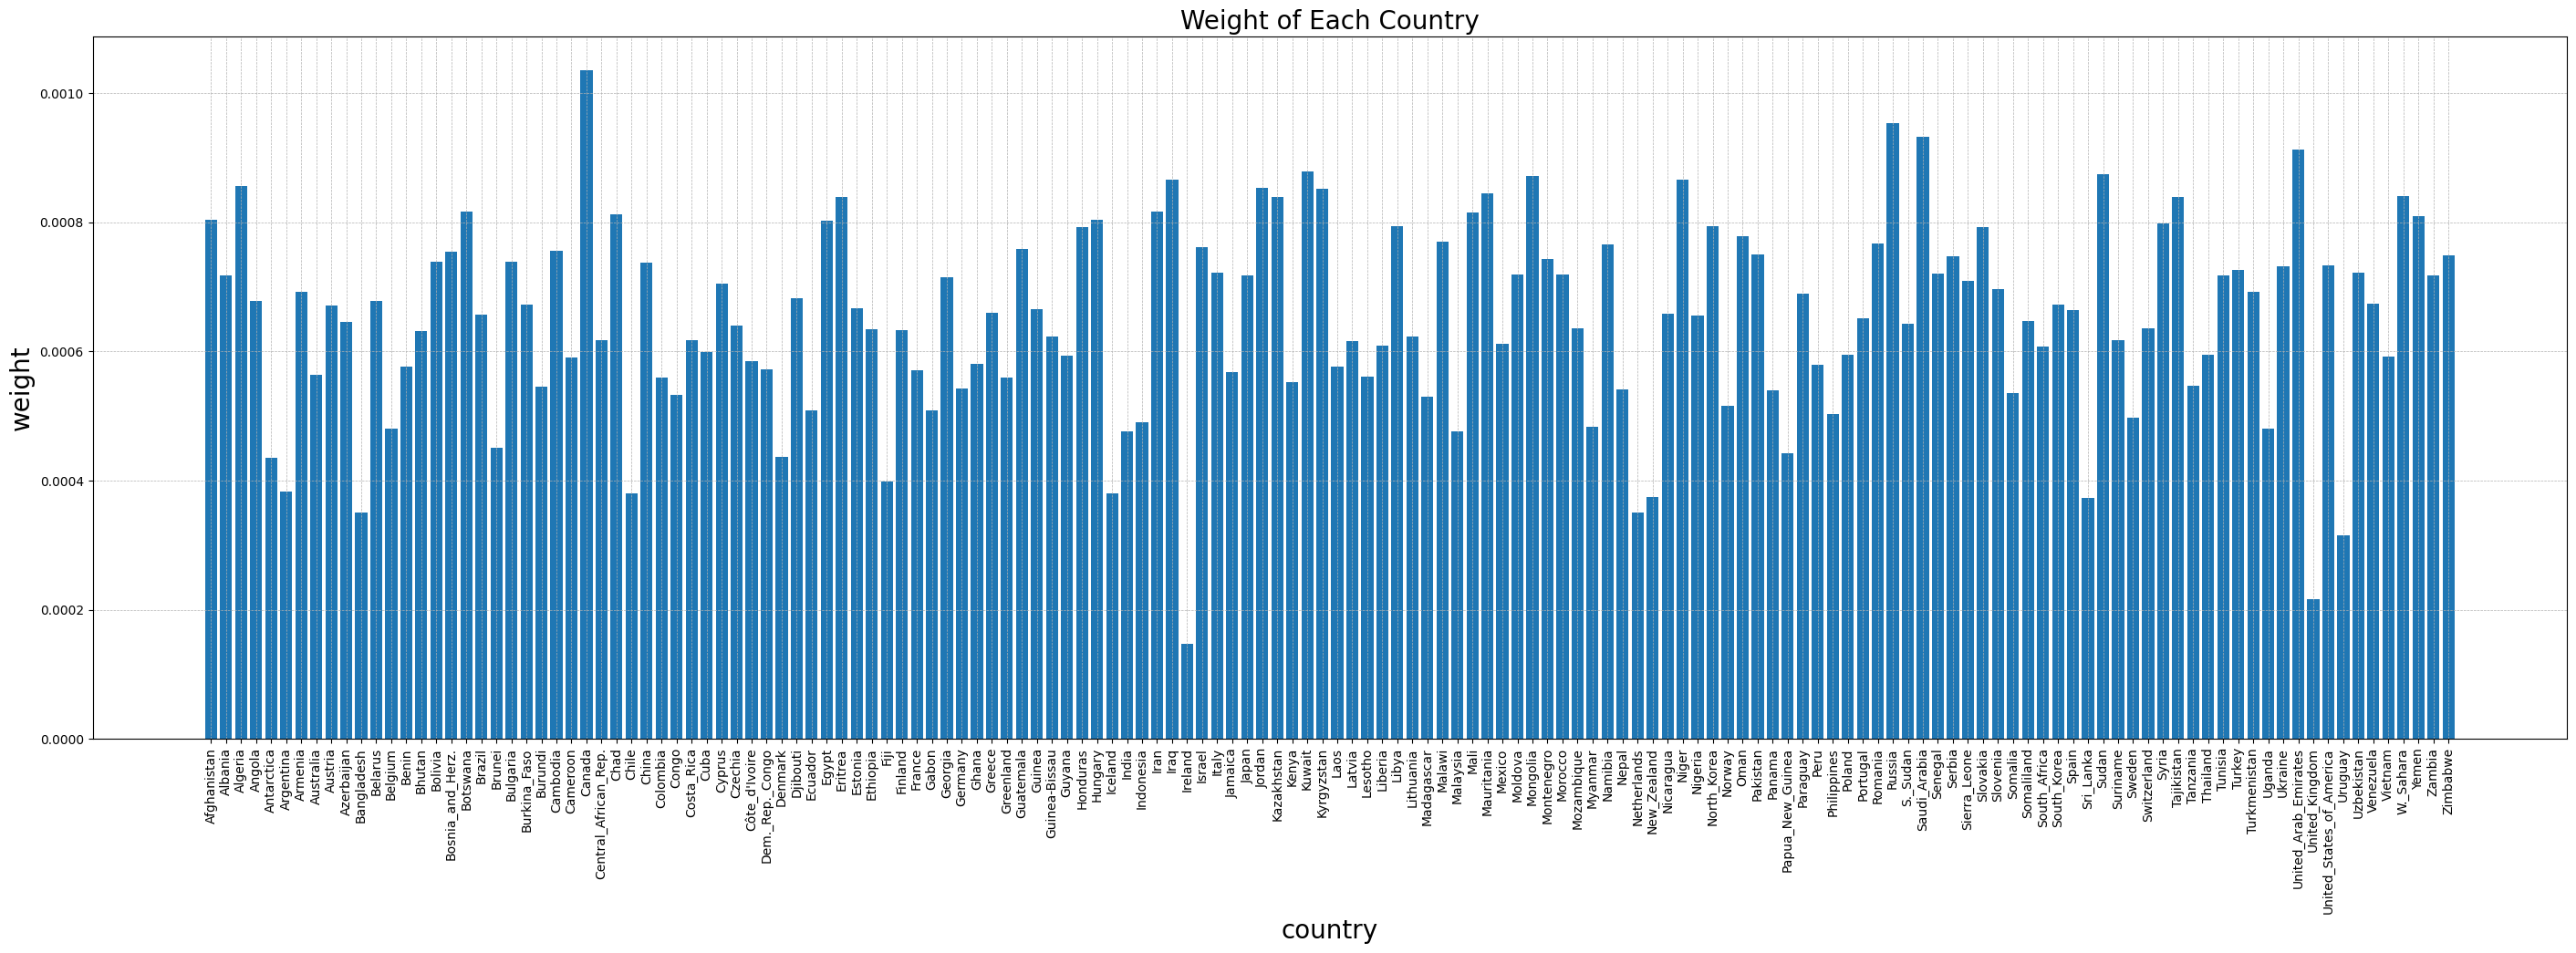

In [34]:
coefs = paras.warming_polyfit_coefficients.sel(degree=1)

## Plot
plot_by_country(x, coefs, 'Weight of Each Country', 'country', 'weight')

In [35]:
## find the biggest weight

find_and_print(coefs, top=True)

the 1 the top value: 0.00103530, Country: Canada
the 2 the top value: 0.00095327, Country: Russia
the 3 the top value: 0.00093223, Country: Saudi_Arabia
the 4 the top value: 0.00091210, Country: United_Arab_Emirates
the 5 the top value: 0.00087867, Country: Kuwait


### Section Summary

Hence, the big-5 countries that sensitive to the CO2 are: Canada, Russia, Saudi_Arabia, Kuwait. They lies in two areas, the north pole, and the mid-east region.

## 6. Do an analysis of your choosing

Maybe dig into the changes in one particular country, or look at changes in the variability of temperature. Perhaps look at the chances of exceeding certian temperature limits. 

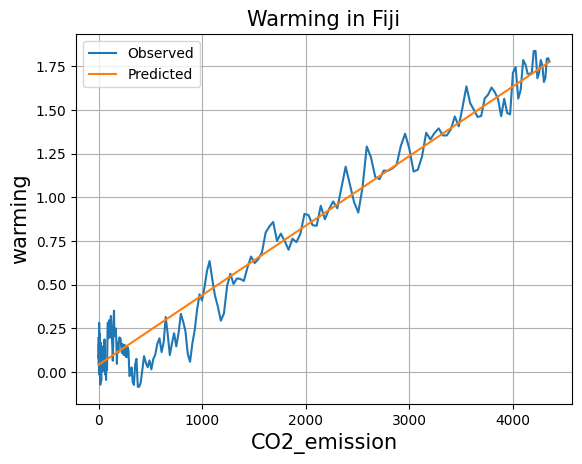

In [28]:
country_to_analysis = 'Fiji'

def plot_country(country_to_analysis):
    """
    Plot the observed vs predicted warming for a given country.

    Args:
        country_to_analysis: The country to plot the data for.
    """
    # Select the data for the specified country
    temp_analysis = temp_by_country.sel(country=country_to_analysis)
    pred_temp_analysis = pred.sel(country=country_to_analysis)

    # Plot observed and predicted warming against CO2 emissions
    plt.plot(temp_analysis.CO2_emission, temp_analysis.warming)
    plt.plot(temp_analysis.CO2_emission, pred_temp_analysis)

    # Label axes and set title
    plt.xlabel('CO2_emission', fontsize=15)
    plt.ylabel('warming', fontsize=15)
    plt.title(f'Warming in {country_to_analysis}', fontsize=15)

    # Display grid, legend, and the plot
    plt.grid()
    plt.legend(['Observed', 'Predicted'])
    plt.show()

plot_country(country_to_analysis)

### Section Summary

I take Fiji for analysis because it is the country that linear regression method works the best. We can see that Fiji's temperature grows as the CO2 concentration grows.

## 7. Make a command line interface to a prediction script 

The inputs should include the name of a country (or global mean) and CO2 concentration(s). It should return the predicted temperature change relative to 1850. You can use the `argparse` package to do this. See [here](https://docs.python.org/3/howto/argparse.html) for documentation. Be sure to check for valid inputs.

Also provide the option to save the predictions to a CSV file.

This script should use the regression coefficients learned in the previous step so it doesn't have to use the full model output each time. You could store them in a numpy file, a pandas CSV file, or even JSON. 

The parameters are saved in **paras.csv**, and the script is in the **script.py**.

In [29]:
# The script is in the file named script.py
! python ./script.py Fiji 4000.897,1235.678,908.776 -s